# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

/home/jiin/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import profile_loader
from optim import Mytrainer
from optim.loss import loss_function,init_center
from datasets import dataloader_pyg as dataloader
from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [8]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
# filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [6]:
def preprocessing(eventID, normalize):
    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

    # define anomaly label
    labels = []
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == accident_sid]
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])
    
    return df_all_norm, label_df, H

In [9]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [10]:
def evaluate(label_all, score_all, adjust = False, plot=False, print_=False):
    true = label_all
    pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    auc = roc_auc_score(true, pred)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(accuracy_score(true, pred)))
        print('AUC score \t{:.4f}'.format(roc_auc_score(true, pred)))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(precision_score(true, pred, pos_label=1)))
        print('Recall   \t{:.4f}'.format(recall_score(true, pred, pos_label=1)))
        print('Macro F1 \t{:.4f}'.format(f1_score(true, pred, average='macro')))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, ap]

## All Results

In [9]:
## load accident_all
accident_all = pd.read_csv('datasets/data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [10]:
accident_all.accident_sid.value_counts()[:10]

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
1130006501    10
1190000200     9
1020000902     9
1220005502     8
1210005402     8
Name: accident_sid, dtype: int64

In [12]:
result_all = []
target_sid = 1030001902 ## 1210005301  ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

for normalize in ['profile', 'standard']:
    # data
    args.dataset = 'Accident_{}'.format(normalize)
    args.normalize = normalize
    df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.01, 0.05, 0.1, 0.2]:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        for name, module in zip(['GCN_sum', 'GCN_rev_sum', 'GraphSAGE_sum', 'GraphSAGE_rev_sum'], ['GCN_gc', 'GCN_gc', 'GraphSAGE_gc', 'GraphSAGE_gc']):
            args.module=module
            args.nu = nu
            train_mode = 'all' # all. select
            # args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
            args.exp_name = f'{args.normalize}_{train_mode}_{name}_{args.nu}_1902'


            checkpoints_path=f'./checkpoints/{args.exp_name}+bestcheckpoint.pt'
            # checkpoints_path=f'./checkpoints/{args.exp_name}+epoch1.pt'
        #     logging.basicConfig(filename=f"./log/{args.exp_name}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
        #     logger=logging.getLogger('OCGNN')
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 24
            model = init_model(args, input_dim)
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center']
            radius = torch.load(checkpoints_path)['radius']
            # print(radius)

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, False, acc, auc, far, pre, rec, macro_f1, ap])
            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, True, acc, auc, far, pre, rec, macro_f1, ap])

/tmp/ipykernel_791207/1432263826.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


train dataset


100%|██████████| 25872/25872 [00:35<00:00, 731.76it/s]


val dataset


100%|██████████| 8904/8904 [00:11<00:00, 767.45it/s]


test dataset


100%|██████████| 8904/8904 [00:11<00:00, 748.94it/s]


403 140 140
##############################
./checkpoints/profile_all_GCN_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:01, 101.15it/s]


tensor(0.0099, device='cuda:0', dtype=torch.float64) 0.020847754050046165


140it [00:00, 251.58it/s]


##############################
./checkpoints/profile_all_GCN_rev_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 261.54it/s]


tensor(0.0093, device='cuda:0', dtype=torch.float64) 0.029402629137039175


140it [00:00, 262.21it/s]


##############################
./checkpoints/profile_all_GraphSAGE_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 301.13it/s]


tensor(0.0018, device='cuda:0', dtype=torch.float64) 0.2971325123310089


140it [00:00, 294.18it/s]


##############################
./checkpoints/profile_all_GraphSAGE_rev_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 285.95it/s]


tensor(0.0033, device='cuda:0', dtype=torch.float64) 0.3024281284213066


140it [00:00, 294.11it/s]


##############################
./checkpoints/profile_all_GCN_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 222.49it/s]


tensor(0.0057, device='cuda:0', dtype=torch.float64) 0.015927464421838525


140it [00:00, 179.27it/s]


##############################
./checkpoints/profile_all_GCN_rev_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 209.18it/s]


tensor(0.0092, device='cuda:0', dtype=torch.float64) 0.011832275986671447


140it [00:00, 177.41it/s]


##############################
./checkpoints/profile_all_GraphSAGE_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 194.26it/s]


tensor(0.0138, device='cuda:0', dtype=torch.float64) 0.2962961092591286


140it [00:00, 192.75it/s]


##############################
./checkpoints/profile_all_GraphSAGE_rev_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 190.72it/s]


tensor(0.0086, device='cuda:0', dtype=torch.float64) 0.2904945179820061


140it [00:00, 205.80it/s]


##############################
./checkpoints/profile_all_GCN_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 186.67it/s]


tensor(0.0137, device='cuda:0', dtype=torch.float64) 0.020327170938253404


140it [00:00, 279.15it/s]


##############################
./checkpoints/profile_all_GCN_rev_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 276.30it/s]


tensor(0.0006, device='cuda:0', dtype=torch.float64) 0.00967356963083148


140it [00:00, 271.16it/s]


##############################
./checkpoints/profile_all_GraphSAGE_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 197.13it/s]


tensor(0.0008, device='cuda:0', dtype=torch.float64) 0.27367825508117677


140it [00:00, 193.65it/s]


##############################
./checkpoints/profile_all_GraphSAGE_rev_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 206.11it/s]


tensor(0.0012, device='cuda:0', dtype=torch.float64) 0.17203539609909058


140it [00:00, 182.91it/s]


##############################
./checkpoints/profile_all_GCN_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 187.78it/s]


tensor(0.0176, device='cuda:0', dtype=torch.float64) 0.01849876083433628


140it [00:00, 269.55it/s]


##############################
./checkpoints/profile_all_GCN_rev_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 282.56it/s]


tensor(0.0150, device='cuda:0', dtype=torch.float64) 0.01729690469801426


140it [00:00, 284.83it/s]


##############################
./checkpoints/profile_all_GraphSAGE_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 311.43it/s]


tensor(0.0163, device='cuda:0', dtype=torch.float64) 0.2993094027042389


140it [00:00, 253.26it/s]


##############################
./checkpoints/profile_all_GraphSAGE_rev_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 264.54it/s]


tensor(0.0073, device='cuda:0', dtype=torch.float64) 0.17004580199718475


140it [00:00, 294.96it/s]
/tmp/ipykernel_791207/1432263826.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


train dataset


100%|██████████| 25872/25872 [00:28<00:00, 922.20it/s] 


val dataset


100%|██████████| 8904/8904 [00:12<00:00, 733.30it/s] 


test dataset


100%|██████████| 8904/8904 [00:13<00:00, 656.21it/s]


403 140 140
##############################
./checkpoints/standard_all_GCN_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 258.64it/s]


tensor(0.0529, device='cuda:0', dtype=torch.float64) 0.772399219870567


140it [00:00, 256.08it/s]


##############################
./checkpoints/standard_all_GCN_rev_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 273.16it/s]


tensor(0.0338, device='cuda:0', dtype=torch.float64) 0.48529309600591586


140it [00:00, 191.62it/s]


##############################
./checkpoints/standard_all_GraphSAGE_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 266.14it/s]


tensor(0.2508, device='cuda:0', dtype=torch.float64) 1.2891952311992632


140it [00:00, 242.99it/s]


##############################
./checkpoints/standard_all_GraphSAGE_rev_sum_0.01_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 181.99it/s]


tensor(0.1448, device='cuda:0', dtype=torch.float64) 1.1517048978805524


140it [00:00, 287.83it/s]


##############################
./checkpoints/standard_all_GCN_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 272.74it/s]


tensor(0.0750, device='cuda:0', dtype=torch.float64) 0.610977327823639


140it [00:00, 248.72it/s]


##############################
./checkpoints/standard_all_GCN_rev_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 272.50it/s]


tensor(0.0396, device='cuda:0', dtype=torch.float64) 0.25146697014570235


140it [00:00, 248.11it/s]


##############################
./checkpoints/standard_all_GraphSAGE_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 284.20it/s]


tensor(0.2218, device='cuda:0', dtype=torch.float64) 1.1038134157657624


140it [00:00, 240.37it/s]


##############################
./checkpoints/standard_all_GraphSAGE_rev_sum_0.05_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 289.46it/s]


tensor(0.2395, device='cuda:0', dtype=torch.float64) 1.1770974695682532


140it [00:00, 271.00it/s]


##############################
./checkpoints/standard_all_GCN_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 270.12it/s]


tensor(0.1566, device='cuda:0', dtype=torch.float64) 0.7570160627365112


140it [00:00, 260.58it/s]


##############################
./checkpoints/standard_all_GCN_rev_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 249.58it/s]


tensor(0.0625, device='cuda:0', dtype=torch.float64) 0.5041799485683441


140it [00:00, 249.02it/s]


##############################
./checkpoints/standard_all_GraphSAGE_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 190.17it/s]


tensor(0.0338, device='cuda:0', dtype=torch.float64) 0.7832562327384949


140it [00:00, 185.73it/s]


##############################
./checkpoints/standard_all_GraphSAGE_rev_sum_0.1_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 188.51it/s]


tensor(0.2309, device='cuda:0', dtype=torch.float64) 1.184272289276123


140it [00:00, 186.31it/s]


##############################
./checkpoints/standard_all_GCN_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 170.90it/s]


tensor(0.0332, device='cuda:0', dtype=torch.float64) 0.06111300289630891


140it [00:00, 207.15it/s]


##############################
./checkpoints/standard_all_GCN_rev_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 263.28it/s]


tensor(0.0168, device='cuda:0', dtype=torch.float64) 0.07396433055400849


140it [00:00, 263.83it/s]


##############################
./checkpoints/standard_all_GraphSAGE_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 293.86it/s]


tensor(0.2502, device='cuda:0', dtype=torch.float64) 1.0880181550979615


140it [00:00, 202.78it/s]


##############################
./checkpoints/standard_all_GraphSAGE_rev_sum_0.2_1902+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 186.40it/s]


tensor(0.2286, device='cuda:0', dtype=torch.float64) 1.003313660621643


140it [00:00, 242.06it/s]


In [13]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'AUC', 'far', 'precision', 'recall', 'F1_score', 'AP'])
result_all


,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
0,GCN_sum,profile,0.01,False,0.978774,0.504262,0.959184,0.040816,0.013889,0.504998,0.016515
1,GCN_sum,profile,0.01,True,0.981244,0.580651,0.661972,0.338028,0.166667,0.606882,0.069815
2,GCN_rev_sum,profile,0.01,False,0.971024,0.493493,1.000000,0.000000,0.000000,0.492650,0.016173
3,GCN_rev_sum,profile,0.01,True,0.971024,0.493493,1.000000,0.000000,0.000000,0.492650,0.016173
4,GraphSAGE_sum,profile,0.01,False,0.977201,0.496632,1.000000,0.000000,0.000000,0.494235,0.016173
...,...,...,...,...,...,...,...,...,...,...,...
59,GCN_rev_sum,standard,0.20,True,0.843553,0.756564,0.933380,0.066620,0.666667,0.517635,0.049804
60,GraphSAGE_sum,standard,0.20,False,0.787848,0.591648,0.969844,0.030156,0.388889,0.468234,0.021611
61,GraphSAGE_sum,standard,0.20,True,0.797731,0.897203,0.925964,0.074036,1.000000,0.511645,0.074036
62,GraphSAGE_rev_sum,standard,0.20,False,0.793014,0.594273,0.969078,0.030922,0.388889,0.470517,0.021908


In [14]:
result_all[(result_all.adjust==True)]

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
1,GCN_sum,profile,0.01,True,0.981244,0.580651,0.661972,0.338028,0.166667,0.606882,0.069815
3,GCN_rev_sum,profile,0.01,True,0.971024,0.493493,1.000000,0.000000,0.000000,0.492650,0.016173
5,GraphSAGE_sum,profile,0.01,True,0.977201,0.496632,1.000000,0.000000,0.000000,0.494235,0.016173
7,GraphSAGE_rev_sum,profile,0.01,True,0.976640,0.496347,1.000000,0.000000,0.000000,0.494091,0.016173
9,GCN_sum,profile,0.05,True,0.961253,0.570491,0.903614,0.096386,0.166667,0.551163,0.029541
11,GCN_rev_sum,profile,0.05,True,0.954964,0.567295,0.921311,0.078689,0.166667,0.541902,0.026592
13,GraphSAGE_sum,profile,0.05,True,0.931491,0.719292,0.881967,0.118033,0.500000,0.577606,0.067103
15,GraphSAGE_rev_sum,profile,0.05,True,0.950696,0.565126,0.930029,0.069971,0.166667,0.536609,0.025139
17,GCN_sum,profile,0.10,True,0.839960,0.754737,0.934827,0.065173,0.666667,0.515363,0.048840
19,GCN_rev_sum,profile,0.10,True,0.889712,0.616096,0.948608,0.051392,0.333333,0.515178,0.027912


In [15]:
result_all.to_csv('result/OCGNN_sumpool_noselfloop_acc1902.csv')

## Case Result

In [11]:
args.dataset = 'Accident_standard'
# args.module = 'GraphSAGE_gc'
args.module = 'GCN_gc'
# args.module = 'STGCN'
name = 'GCN_sum'
args.normalize = 'standard'
args.nu = 0.05
train_mode = 'all'
# args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
args.exp_name = f'{args.normalize}_{train_mode}_{name}_{args.nu}_5301'


In [12]:
checkpoints_path=f'./checkpoints/{args.exp_name}+bestcheckpoint.pt'
logging.basicConfig(filename=f"./log/{args.exp_name}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
logger=logging.getLogger('OCGNN')
checkpoints_path

'./checkpoints/standard_all_GCN_sum_0.05_5301+bestcheckpoint.pt'

In [13]:
args.normalize

'standard'

In [15]:
    target_sid = 1210005301 ## 1210005301 ## 1030001902
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    # args.normalize = normalize
    
    df_all_norm, label_df, H = preprocessing(eventID, args.normalize)

/tmp/ipykernel_3842294/1432263826.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


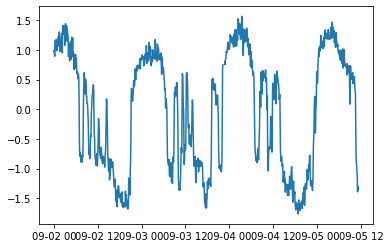

In [16]:
plt.plot(df_all_norm.iloc[:1000][target_sid])

In [17]:
train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
len(train_loader), len(val_loader), len(test_loader)

train dataset


  0%|          | 0/25872 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  data[key] = torch.tensor(value)
100%|██████████| 25872/25872 [00:27<00:00, 956.47it/s] 


val dataset


100%|██████████| 8904/8904 [00:09<00:00, 979.77it/s] 


test dataset


100%|██████████| 8904/8904 [00:08<00:00, 1097.76it/s]


(403, 140, 140)

In [43]:
## Normal Data Plot
# for i, data in enumerate(train_loader):
#     print(data.x)
#     plt.figure()
#     plt.plot(data.x[2])
#     plt.axhline(data.x[2].mean(), alpha=0.5, color='k')
#     if i == 10:
#         break

## Incident Data Plot
# for ix, row in accident_case.iterrows():
#     t = row['created']
#     plt.figure()
#     plt.plot(df_all_norm.loc[(df_all_norm.index > t+timedelta(minutes=-60)) & (df_all_norm.index <= t+timedelta(minutes=60))][accident_sid])

In [18]:
input_dim = 24
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of GCN_gc Net is: 7840


In [19]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path)['model'])
model.eval()
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']
model, data_center, radius

./checkpoints/standard_all_GCN_sum_0.05_5301+bestcheckpoint.pt


(GCN_gc(
   (layers): ModuleList(
     (0): GCNConv(24, 64)
     (1): GCNConv(64, 64)
   )
   (outlayer): GCNConv(64, 32)
   (dropout): Dropout(p=0.25, inplace=False)
 ),
 tensor([  1.7384,  -4.4162,   2.3556,   1.8639,   3.1291, -15.2570,   6.7504,
           6.9682,  -0.1512,  -4.4031,  -3.5347,  -4.5409,  14.0671,  -7.0451,
           3.3820,  10.9057,  -7.4325,   5.4826,   4.2738,   0.5064,  -7.7455,
          11.1121,  -3.2675,  -3.9748,  -3.4305,  -6.5651,  -2.6572,  -1.6395,
          -6.0533,  -2.1214,   1.8019,  -5.6836], device='cuda:0'),
 tensor(0.6206, device='cuda:0', dtype=torch.float64))

In [20]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

20it [00:01, 23.75it/s]

tensor([ 1.7399, -4.3797], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.7557, -4.3860], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.7272, -4.4922], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.8771, -4.3640], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.7542, -4.3818], device='cuda:0', grad_fn=<SliceBackward0>)


140it [00:01, 78.01it/s] 

[0.12542811 0.09134938 0.13277186 0.1076361  0.09507971]


0.5997415304183961

In [21]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

140it [00:00, 236.15it/s]


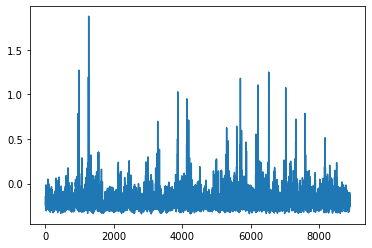

In [22]:
plt.plot(score_all)

Accuracy 	0.9378
AUC score 	0.5129
FAR score 	0.9707
Precision 	0.0293
Recall   	0.0714
Macro F1 	0.5047
Avg Precision 	0.0196
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      8736
           1       0.03      0.07      0.04       168

    accuracy                           0.94      8904
   macro avg       0.51      0.51      0.50      8904
weighted avg       0.96      0.94      0.95      8904



[0.9377807726864331,
 0.5129349816849816,
 0.9707317073170731,
 0.02926829268292683,
 0.07142857142857142,
 0.504684635111769,
 0.019610807967917955]

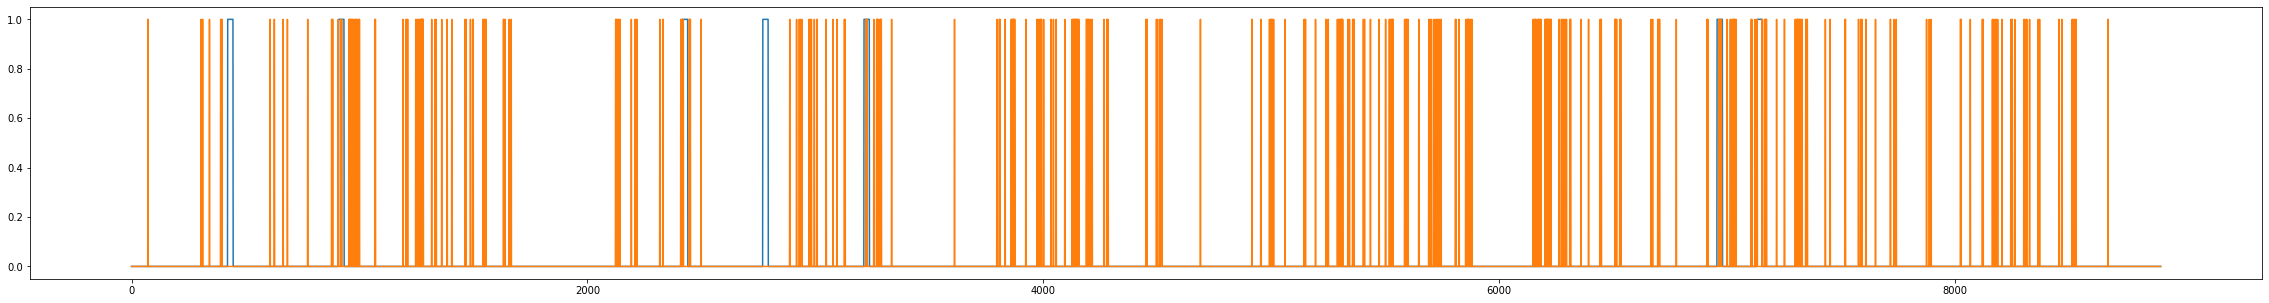

In [23]:
evaluate(label_all, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9499
AUC score 	0.8344
FAR score 	0.7683
Precision 	0.2317
Recall   	0.7143
Macro F1 	0.6619
Avg Precision 	0.1709
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8736
           1       0.23      0.71      0.35       168

    accuracy                           0.95      8904
   macro avg       0.61      0.83      0.66      8904
weighted avg       0.98      0.95      0.96      8904



[0.9499101527403414,
 0.8343635531135533,
 0.7683397683397684,
 0.23166023166023167,
 0.7142857142857143,
 0.6619029342843317,
 0.17086242962253745]

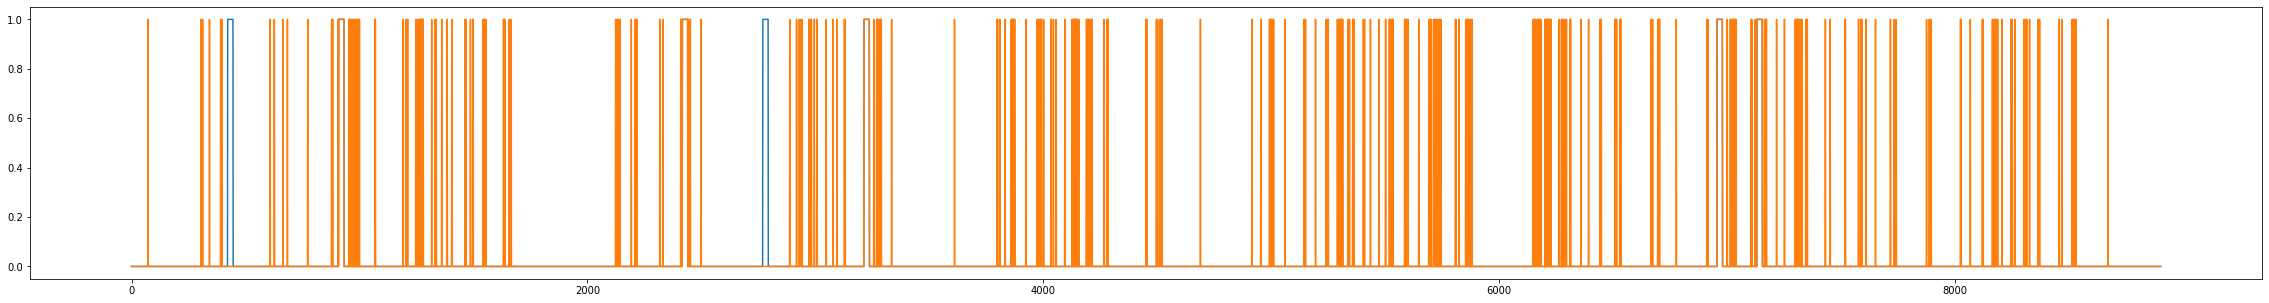

In [24]:
evaluate(label_all, score_all, adjust=True, plot=True, print_=True)

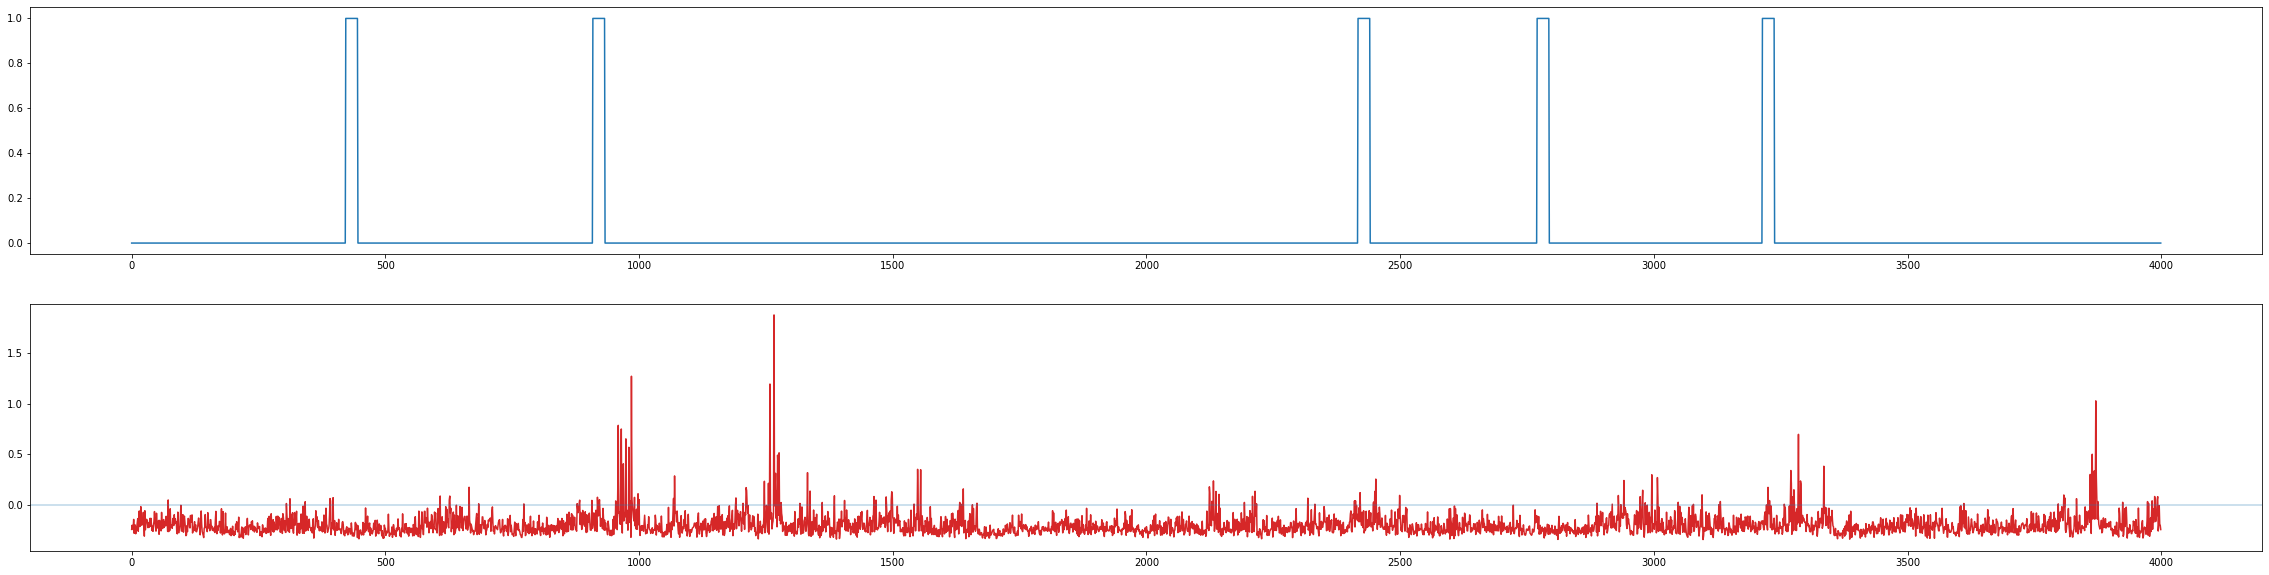

In [25]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


In [197]:
# def Cumulative(lists, window=12):
#     cu_list = []
#     length = len(lists)
#     cu_list = [(lists[x-window:x].mean()) for x in range(window, length)]
#     return cu_list + [0]*window

# # plt.plot(Cumulative(score_all, window=2))
# cum_score_all = Cumulative(score_all, window=)
# evaluate(label_all, cum_score_all, adjust=True, plot=False, print_=True)

## Case prediction plot

In [57]:
tmp = np.argsort(dist_all)[::-1][:10]
tmp

array([1266,  985, 6532, 1258, 5703, 6215, 6223, 7029, 3871, 6213])

In [50]:
dist_all[1266]

2.2357154

In [53]:
len(dist_all)

8904

In [45]:
with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]
test_df = test_df.rolling(window=6).mean()

In [46]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

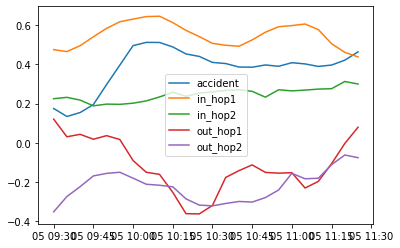

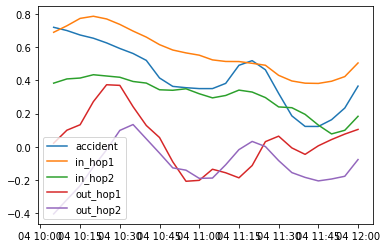

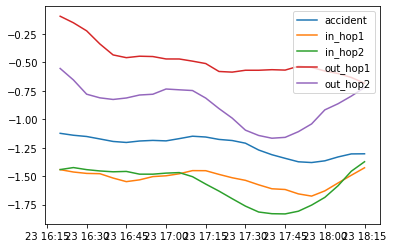

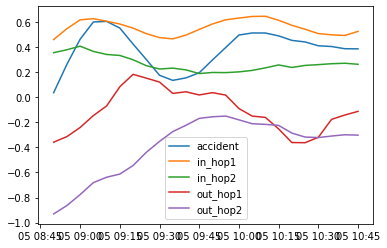

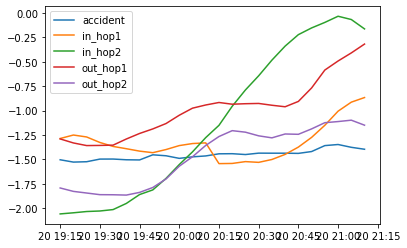

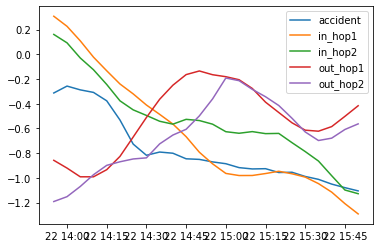

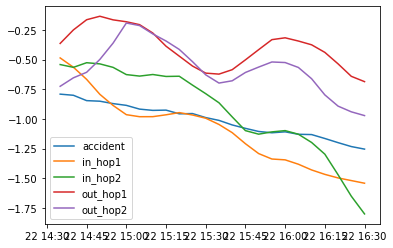

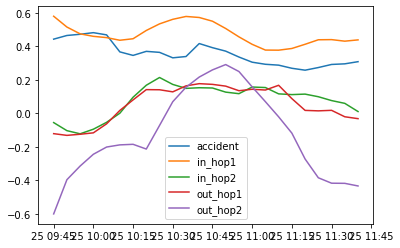

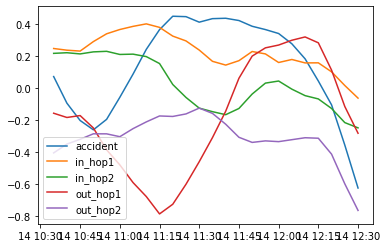

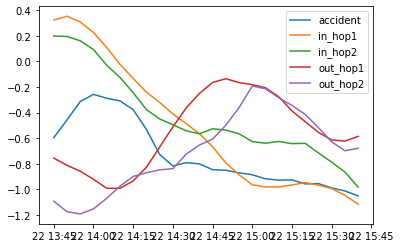

In [59]:
for i in tmp:
    plt.figure()
    plt.plot(df_agg_inflow[i:i+24][0], label='accident')
    plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
    plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
    plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
    plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
    plt.legend()
    plt.show()
    

In [26]:
label_df['weekday'] = label_df.index.weekday
label_df['timestamp'] = label_df.index.time
test_label_df = label_df[label_df.index >= datetime(2020, 12, 1)].iloc[12:]

In [27]:
profile_mean.reset_index(inplace=True)

NameError: name 'profile_mean' is not defined

In [ ]:
# pred = list(map(int, [s>0 for s in score_all]))
new_score = []
for i, dt in enumerate(test_label_df.index):
    weekday = test_label_df.iloc[i]['weekday']
    timestamp = test_label_df.iloc[i]['timestamp']
    if score_all[i] > 0:
        if profile_mean[(profile_mean.weekday == 0) & (profile_mean.timestamp == timestamp)].iloc[:, 2:].mean(axis=1).item() < 50:
            new_score.append(0)
        else:
            new_score.append(score_all[i])
    else:
        new_score.append(score_all[i])


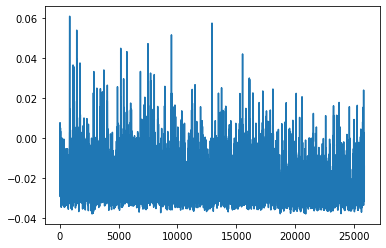

In [ ]:
plt.plot(new_score)

AUC score 0.4925009987861712
FAR score 0.024461724825133837
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     25591
           1       0.00      0.01      0.01       317

    accuracy                           0.96     25908
   macro avg       0.50      0.49      0.49     25908
weighted avg       0.98      0.96      0.97     25908



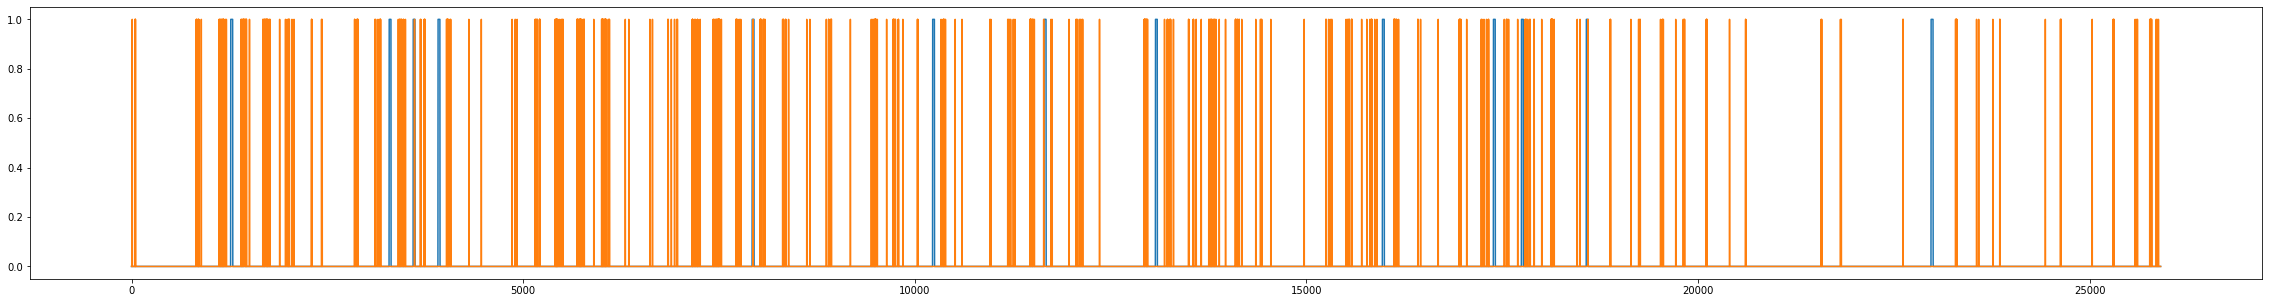

In [ ]:
evaluate(label_all, new_score, adjust=False, plot=True)

AUC score 0.6013338063571492
FAR score 0.024461724825133837
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     25591
           1       0.10      0.23      0.14       317

    accuracy                           0.97     25908
   macro avg       0.55      0.60      0.56     25908
weighted avg       0.98      0.97      0.97     25908



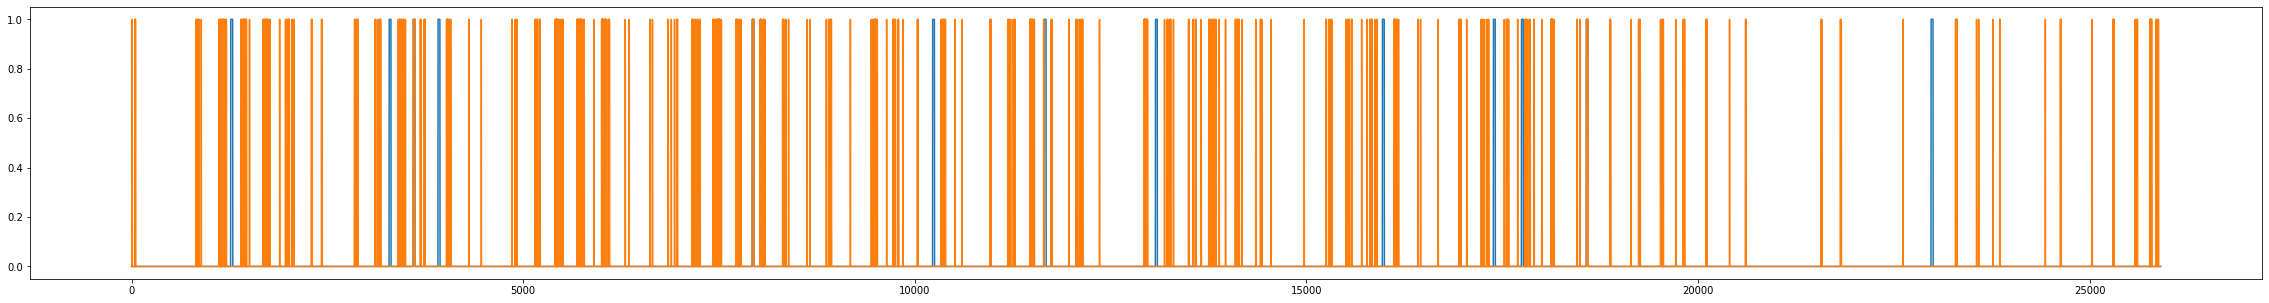

In [ ]:
evaluate(label_all, new_score, adjust=True, plot=True)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff8c0a8edc0>
Traceback (most recent call last):
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/tmp/ipykernel_2702016/3153301662.py:18: UserWarning: The palette list has more valu

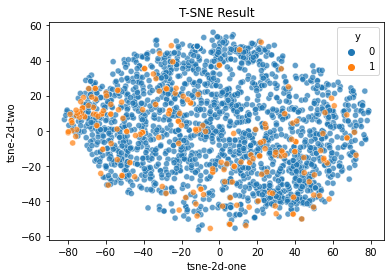

/tmp/ipykernel_2702016/3153301662.py:40: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


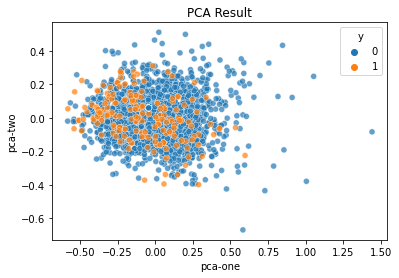

In [37]:
import seaborn as sns 

rndperm = np.random.permutation(2000)


normal = np.where(label_all == 0)
abnormal = np.where(label_all == 1)

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_all = tsne.fit_transform(np.concatenate(out_all))

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = label_all

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(np.concatenate(out_all))

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = label_all

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)

plt.title('PCA Result')
plt.show()

In [ ]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# tsne_all = tsne.fit_transform(np.concatenate(out_all))

# normal = np.where(label_all == 0)
# abnormal = np.where(label_all == 1)

# normal_tsne = tsne_all[normal[0]]
# abnormal_tsne = tsne_all[abnormal[0]]
# # for i in range(len(normal_tsne)):
# for i in range(1000):
#     plt.scatter(normal_tsne[i, 0], normal_tsne[i,1], color='tab:green', s=15)
# for i in range(len(abnormal_tsne)):
#     plt.scatter(abnormal_tsne[i, 0], abnormal_tsne[i,1], color='tab:red', s=7)

# # plt.xlim(-0.005, 0.005)
# # plt.ylim(-0.005, 0.005)
# plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca_all = pca.fit_transform(np.concatenate(out_all))

# normal = np.where(label_all == 0)
# abnormal = np.where(label_all == 1)

# normal_pca = pca_all[normal[0]]
# abnormal_pca = pca_all[abnormal[0]]
# # for i in range(len(normal_pca)):
# for i in range(1000):
#     plt.scatter(normal_pca[i, 0], normal_pca[i,1], color='tab:green', s=15)
# for i in range(len(abnormal_pca)):
#     plt.scatter(abnormal_pca[i, 0], abnormal_pca[i,1], color='tab:red', s=7)

# plt.show()

In [201]:
normal = np.where(label_all == 0)
abnormal = np.where(label_all == 1)

([<matplotlib.axis.XTick at 0x7ffa293cd7f0>,
 [Text(1, 0, 'normal'), Text(2, 0, 'abnormal')])

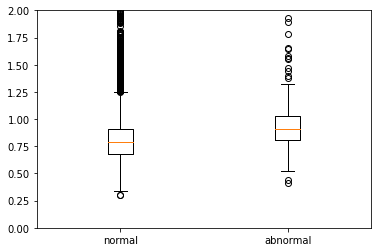

In [203]:
plt.boxplot([dist_all[normal[0]], dist_all[abnormal[0]]])
plt.ylim(0, 2)
plt.xticks([1, 2],['normal', 'abnormal'])

In [121]:
dist_all[normal[0]].mean() <  dist_all[abnormal[0]].mean()

AttributeError: 'numpy.ndarray' object has no attribute 'median'

## 1902 + 5301

In [36]:
out_sumpool_5301 = pd.read_csv('result/OCGNN_sumpool_acc5301.csv', index_col=0)
out_sumpool_1902 = pd.read_csv('result/OCGNN_sumpool_acc1902.csv', index_col=0)

In [37]:
out_sumpool_5301['pooling'] = 'sum'
out_sumpool_1902['pooling'] = 'sum'

In [41]:
out_sumpool = out_sumpool_5301.copy()
out_sumpool.iloc[:, 4:-1] = (out_sumpool_5301.iloc[:, 4:-1] + out_sumpool_1902.iloc[:, 4:-1])/2
out_sumpool

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP,pooling
0,GCN_gc,standard,0.05,False,0.937037,0.498027,0.987178,0.012822,0.046822,0.493745,0.013495,sum
1,GCN_gc,standard,0.05,True,0.943852,0.749310,0.867412,0.132588,0.549389,0.591962,0.078745,sum
2,GCN_traffic,standard,0.05,False,0.949896,0.490901,0.993196,0.006804,0.019129,0.492162,0.013424,sum
3,GCN_traffic,standard,0.05,True,0.952946,0.612892,0.919920,0.080080,0.263111,0.549208,0.042544,sum
4,GraphSAGE_gc,standard,0.05,False,0.953603,0.491720,0.992717,0.007283,0.017001,0.493152,0.013426,sum
5,GraphSAGE_gc,standard,0.05,True,0.956615,0.602502,0.906423,0.093577,0.238565,0.555500,0.032447,sum
6,GCN_gc,standard,0.10,False,0.845304,0.479142,0.990473,0.009527,0.102704,0.466461,0.013146,sum
7,GCN_gc,standard,0.10,True,0.853723,0.787214,0.930209,0.069791,0.718849,0.523047,0.054706,sum
8,GCN_traffic,standard,0.10,False,0.903808,0.491957,0.989213,0.010787,0.068628,0.484028,0.013399,sum
9,GCN_traffic,standard,0.10,True,0.912728,0.826038,0.894636,0.105364,0.736790,0.569068,0.082211,sum
